# **Conformal Pipeline**

Wrapping some point estimates

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from collections import defaultdict

from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
import matplotlib.dates as mdates
import seaborn as sns
import re
from typing import Dict, Any
from tqdm.notebook import tqdm
import bisect
from joblib import Parallel, delayed

from ACI import *       # Gibbs & Candes (2021)
from agACI import *     # Zaffran et Al. (2022)
from dtACI import *     # Gibbs & Candes (2024)

**Load Point Forecasts**

In [5]:
forecasts = pd.read_pickle("new.pkl")
# tag Hs (1-6)
forecasts['H'] = (np.arange(len(forecasts)) % 6) + 1
rename_map = {
    "actual": "y",
    "stgcn": "STGCN",
    "lgbm_direct_median": "LGBM",
    "arima": "ARIMA",
    "lgbm_direct_lower": "LGBM_low",
    "lgbm_direct_upper": "LGBM_high",
}

forecasts = forecasts.rename(columns=rename_map)
forecasts.head(2)

,y,STGCN,LGBM,ARIMA,LGBM_low,LGBM_high,H
2023-01-01 00:00:00+00:00,7851.432129,7889.245605,6626.377263,7660.308668,5668.209283,7222.207512,1
2023-01-01 01:00:00+00:00,8088.687012,7974.226074,6579.910121,7489.318373,5178.847177,7476.828777,2


**Are they good?**

In [46]:
models = ["STGCN", "LGBM", "ARIMA"]

# --- 1. Total RMSE and MAE ---
total_results_df = pd.DataFrame(
    {
        "Total MAE": [(forecasts[m] - forecasts["y"]).abs().mean() for m in models],
        "Total RMSE": [np.sqrt(((forecasts[m] - forecasts["y"])**2).mean()) for m in models],
    },
    index=models
)

# --- 2. RMSE and MAE by H ---
def calc_metrics(group):
    metrics = {}
    for m in models:
        err = group[m] - group["y"]
        metrics[(m, "MAE")] = err.abs().mean()
        metrics[(m, "RMSE")] = np.sqrt((err**2).mean())
    return pd.Series(metrics)

# H_results_df = forecasts.groupby("H").apply(calc_metrics)
H_results_df = forecasts.groupby("H").apply(calc_metrics, include_groups=False)
H_results_df.columns = pd.MultiIndex.from_tuples(H_results_df.columns)


# --- 3. Display ---
print("Total Point Prediction Errors (Overall/Avg)")
print(total_results_df)

print("\n" + "="*50 + "\n")

print("Point Prediction Errors by Horizon")
print(H_results_df)

Total Point Prediction Errors (Overall/Avg)
         Total MAE   Total RMSE
STGCN  1220.294922  1704.355347
LGBM   1682.850268  2368.271967
ARIMA  2408.405544  3337.951551


Point Prediction Errors by Horizon
         STGCN                      LGBM                     ARIMA  \
           MAE         RMSE          MAE         RMSE          MAE   
H                                                                    
1   854.297424  1201.969604  1522.548210  2195.446677  2392.065505   
2  1035.808960  1433.287598  1597.225626  2282.817071  2392.591941   
3  1203.761719  1679.205811  1670.963588  2358.872212  2407.871815   
4  1293.820923  1776.835449  1728.616340  2395.172449  2399.015264   
5  1409.417725  1925.504395  1765.030502  2449.627417  2429.330557   
6  1524.662964  2060.455322  1812.717344  2513.807694  2429.558185   

                
          RMSE  
H               
1  3350.961316  
2  3344.814734  
3  3347.049393  
4  3313.715894  
5  3340.743000  
6  3330.282202  


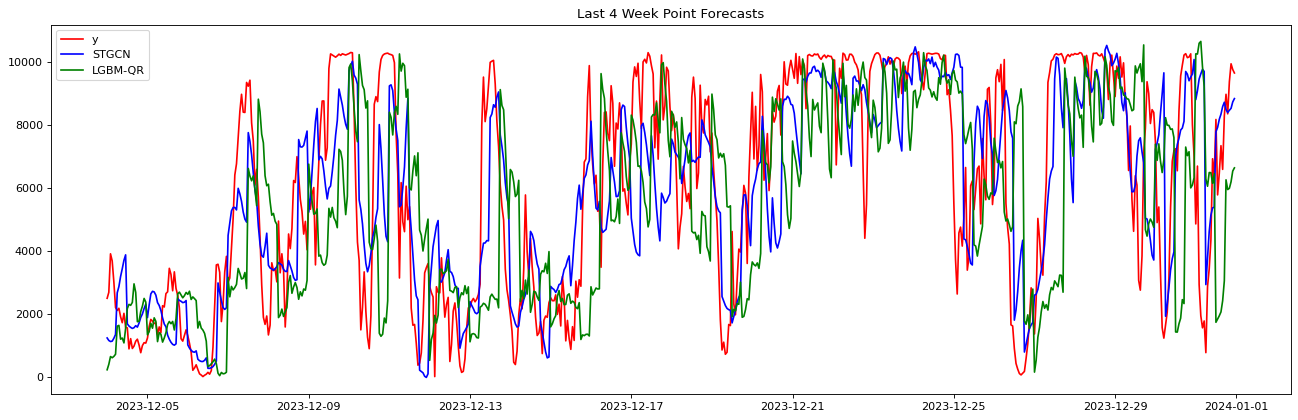

In [8]:
plt.figure(figsize=(20, 6), dpi=80)
last_n = 168*4
plt.plot(forecasts.index[-last_n:], forecasts['y'].tail(last_n), label="y", color = "red")
plt.plot(forecasts.index[-last_n:], forecasts['STGCN'].tail(last_n), label="STGCN", color = "blue")
plt.plot(forecasts.index[-last_n:], forecasts['LGBM'].tail(last_n), label="LGBM-QR", color = "green")
plt.legend();plt.title(f"Last {int(last_n/168)} Week Point Forecasts");plt.show()

## **Conformal Inference**

In [ ]:
def run_online(
    y: np.ndarray,
    preds: np.ndarray,
    alpha: float = 0.1,
    gamma: float = 0.001,
    gammas: np.ndarray = None,
    I: int = 50,
    window_size: int = 100,
    track_adaptations: bool = False,
    warmup_frac: float = 0.3,
    timestamps: np.ndarray = None,
    verbose: bool = False,
    **kwargs
) -> Dict[str, Dict[str, Any]]:
    """Runs online conformal prediction for all methods, including OSSCP."""
    T = len(y)
    warmup = int(T * warmup_frac)
    methods = ["osscp", "aci", "dtaci", "agaci"]
    
    if gammas is None:
        gammas = np.full(T, gamma)

    # Parallelize across methods
    results_list = Parallel(n_jobs=-1, prefer="threads")(
        delayed(_run_single_method)(
            method, y, preds, alpha, gammas, I, window_size, 
            track_adaptations, warmup, timestamps, verbose, **kwargs
        ) for method in methods
    )
    
    # Combine results
    results = {}
    for method_results in results_list:
        results.update(method_results)
    
    return results


def _run_single_method(method, y, preds, alpha, gammas, I, window_size, 
                      track_adaptations, warmup, timestamps, verbose, **kwargs):
    """Run a single method (possibly with multiple gamma values for ACI)."""
    T = len(y)
    results = {}
    
    # Special case: ACI tests both gamma (0.001, 0.05)
    gamma_list = [None] if method != "aci" else [gammas[0], gammas[-1]]
    
    for gamma_val in gamma_list:
        residuals = list(np.abs(y[:warmup] - preds[:warmup]))
        sorted_residuals = sorted(residuals)
        alpha_t = alpha
        betas = []
        
        # Pre-allocate storage & optional trackers
        n_steps = T - warmup
        covers = np.empty(n_steps, dtype=bool)
        lengths = np.empty(n_steps)
        lower_bounds = np.empty(n_steps)
        upper_bounds = np.empty(n_steps)

        alpha_hist = np.empty(n_steps) if track_adaptations else None
        cover_hist = np.empty(n_steps, dtype=bool) if track_adaptations else None
        res_hist = np.empty(n_steps) if track_adaptations else None
        
        iterator = range(warmup, T)
        if verbose:
            iterator = tqdm(iterator, desc=f"{method.upper()}", leave=False)
        
        # sequential (each t) 
        for i, t in enumerate(iterator):
            # quantile computation
            if method == "osscp":
                q = np.quantile(residuals[-window_size:], 1 - alpha)
            else:
                alpha_t = np.clip(alpha_t, 1e-6, 1.0 - 1e-6)
                q = np.quantile(residuals, 1 - alpha_t)
            
            # Prediction interval
            lower, upper = preds[t] - q, preds[t] + q
            res_t = abs(y[t] - preds[t])

            # store
            covers[i] = (y[t] >= lower) and (y[t] <= upper)
            lengths[i] = max(0, upper - lower)
            lower_bounds[i] = lower
            upper_bounds[i] = upper
            
            # Update residuals
            residuals.append(res_t)
            bisect.insort(sorted_residuals, res_t)
            
            # update alpha (ACI methods)
            if method != "osscp":
                if method == "aci":
                    beta = int(covers[i])
                    out = aci(np.array(betas + [beta]), alpha, gamma_val, **kwargs)
                else:
                    # Fast beta computation (thanks gpt)
                    idx = bisect.bisect_right(sorted_residuals, res_t)
                    beta = (len(sorted_residuals) - idx) / len(sorted_residuals)
                    
                    if method == "agaci":
                        out = agaci(np.array(betas + [beta]), alpha, gammas, **kwargs)
                    elif method == "dtaci":
                        I_curr = min(I, len(betas) + 1)
                        out = dtaci(np.array(betas + [beta]), alpha, gammas, I=I_curr, **kwargs)
                
                betas.append(beta)
                alpha_t = out["alphaSeq"][-1]

            # Optional tracking
            if track_adaptations:
                alpha_hist[i] = alpha if method == "osscp" else alpha_t
                cover_hist[i] = covers[i]
                res_hist[i] = res_t
        
        # results
        key_name = method if method != "aci" else f"aci_gamma{gamma_val:.3f}"
        results[key_name] = {
            "coverage": covers.mean(),
            "median_len": np.median(lengths),
            "timestamps": timestamps[warmup:] if timestamps is not None else None,
            "lower_bounds": lower_bounds,
            "upper_bounds": upper_bounds,
            "alpha_hist": alpha_hist if track_adaptations else None,
            "cover_hist": cover_hist if track_adaptations else None,
            "res_hist": res_hist if track_adaptations else None,
        }
    
    return results


def run_mult_aci(
    forecasts_df: pd.DataFrame,
    H_col: str = "H",
    actual_col: str = "y",
    pred_col: str = "stgcn",
    gammas: np.ndarray = None,
    verbose: bool = False,
    n_jobs: int = -1,
    **kwargs
) -> Dict[int, Dict[str, Dict[str, Any]]]:
    """
    Run OCP on DataFrame grouped by H, parallelized across horizons.
    
    Args:
        n_jobs: Number of parallel jobs. -1 uses all available cores.
    """
    # Group by horizon
    horizon_groups = list(forecasts_df.groupby(H_col))
    
    if verbose:
        print(f"Processing {len(horizon_groups)} horizons in parallel...")
    
    # Parallelise horizons
    results_list = Parallel(n_jobs=n_jobs, verbose=0)(
        delayed(_process_horizon)(
            H_level, group_df, actual_col, pred_col, gammas, verbose, **kwargs
        ) for H_level, group_df in tqdm(horizon_groups, desc="Horizons", leave=True)
    )
    
    # Combine results
    return dict(results_list)


def _process_horizon(H_level, group_df, actual_col, pred_col, gammas, verbose, **kwargs):
    """Process a single forecast horizon."""
    y_true_h = group_df[actual_col].values
    y_preds_h = group_df[pred_col].values
    timestamps_h = group_df.index.values
    
    H_results = run_online(
        y=y_true_h,
        preds=y_preds_h,
        timestamps=timestamps_h,
        gammas=gammas,
        verbose=verbose,
        **kwargs,
    )
    
    return H_level, H_results

In [64]:
results = {}
for model in models:
    results[model] = run_mult_aci(
        forecasts_df=forecasts,
        H_col="H",
        actual_col="y",
        pred_col=model,
        alpha=0.1,
        gamma=0.001,
        gammas=np.linspace(0.001, 0.05, 50),
        I=168,
        window_size=168,
        track_adaptations=True,
        warmup_frac=0.5
    )

Horizons: 100%|████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 6000.43it/s]


In [ ]:
for alpha in [0.5, 0.6, 0.8, 0.9, 0.99]:
    

Text(0.5, 1.0, 'Out-of-Sample Power Output (kW) ACI')

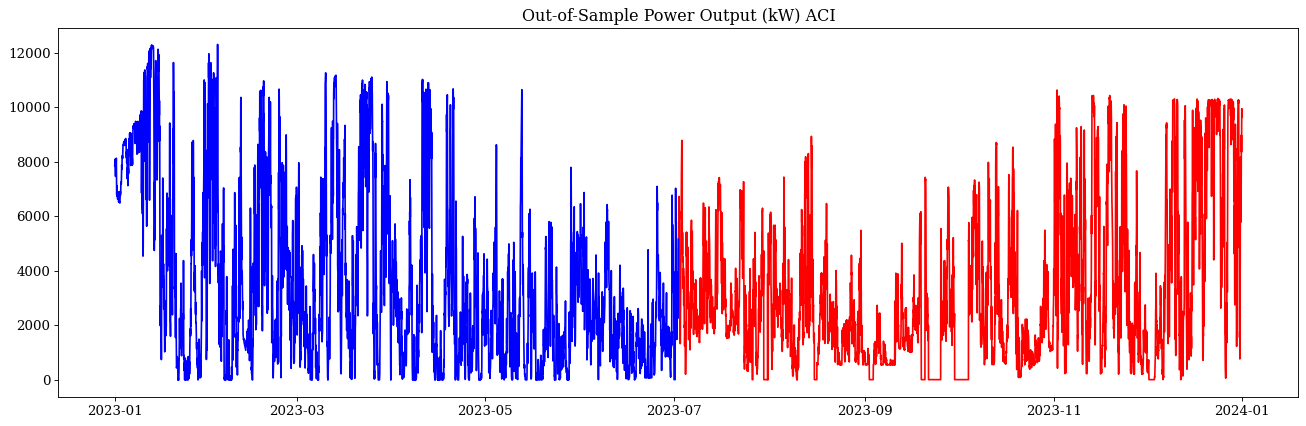

In [32]:
plt.figure(figsize=(20, 6), dpi=80)
plt.plot(forecasts['y'].iloc[len(forecasts) // 2 :].index, forecasts['y'].iloc[len(forecasts) // 2 :], label="Online Test", color = "red")
plt.plot(forecasts['y'].iloc[:len(forecasts) // 2].index, forecasts['y'].iloc[:len(forecasts) // 2], label="Warmup", color = "blue")
plt.title("Out-of-Sample Power Output (kW) ACI")

### Results plots

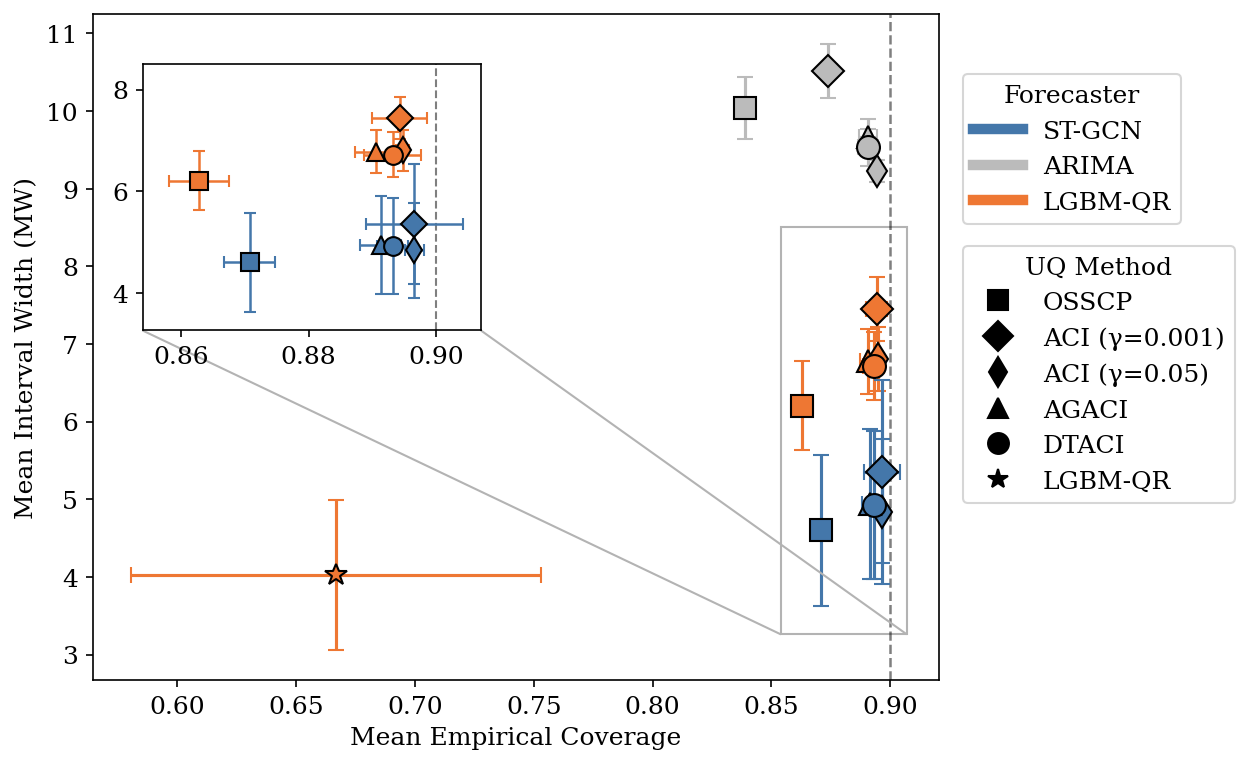

In [171]:
def compute_interval_metrics(df, low, high, actual="y"):
    """Computes coverage and median width for prediction intervals."""
    in_bounds = (df[actual] >= df[low]) & (df[actual] <= df[high])
    return {"coverage": in_bounds.mean(), "median_len": (df[high] - df[low]).median()}

results.setdefault("LGBM", {})
for h in forecasts["H"].unique():
    subset = forecasts[forecasts["H"] == h]
    metrics = compute_interval_metrics(subset, "LGBM_low", "LGBM_high")
    results["LGBM"].setdefault(h, {}).update({"NATIVE": metrics})

results_df = pd.DataFrame([
    {
        "Model": model.upper().replace("_", "-"), "Horizon": h, "Method": method.upper(),
        "Coverage": metrics.get("coverage"), "Width": metrics.get("median_len")
    }
    for model, horizons in results.items()
    for h, methods in horizons.items()
    for method, metrics in methods.items()
])

def plot_final_tradeoff(df: pd.DataFrame, alpha: float = 0.1, output_filename="tradeoff_plot.pdf"):
    """Generates a high-quality trade-off plot with a zoomed-in inset."""
    plt.style.use('default')
    plt.rcParams.update({"font.family": "serif", "font.size": 12, "figure.dpi": 150})

    aesthetics = {
        "colors": {"STGCN": "#4477AA", "ARIMA": "#BBBBBB", "LGBM": "#EE7733"},
        "markers": {"OSSCP": "s", "ACI_GAMMA0.001": "D", "ACI_GAMMA0.050": "d", "AGACI": "^", "DTACI": "o", "NATIVE": "*"},
        "model_names": {"STGCN": "ST-GCN", "ARIMA": "ARIMA", "LGBM": "LGBM-QR"},
        "method_names": {"OSSCP": "OSSCP", "ACI_GAMMA0.001": "ACI (γ=0.001)", "ACI_GAMMA0.050": "ACI (γ=0.05)", "AGACI": "AGACI", "DTACI": "DTACI", "NATIVE": "LGBM-QR"}
    }
    
    fig, ax = plt.subplots(figsize=(8, 6))

    # Helper function to avoid repeating plot code
    def draw_data(target_ax, **kwargs):
        for (model, method), group in df.groupby(["Model", "Method"]):
            target_ax.errorbar(
                x=group['Coverage'].mean(), y=group['Width'].mean() / 1000,
                xerr=group['Coverage'].std(), yerr=group['Width'].std() / 1000,
                marker=aesthetics["markers"].get(method, 'x'),
                color=aesthetics["colors"].get(model, 'k'),
                linestyle='None', markeredgecolor='black', zorder=10, **kwargs
            )

    # Main plot
    draw_data(ax, markersize=11, elinewidth=1.5, capsize=4)
    ax.set(xlabel="Mean Empirical Coverage", ylabel="Mean Interval Width (MW)")
    ax.axvline(1 - alpha, color='k', linestyle='--', linewidth=1.2, alpha=0.5, zorder=5)

    # Inset plot (zoomed view)
    axins = inset_axes(ax, width="40%", height="40%", loc="upper left", borderpad=2)
    draw_data(axins, markersize=9, elinewidth=1.2, capsize=3)
    axins.set_xlim(0.854, 0.907)
    axins.set_ylim(3.26, 8.5)
    axins.axvline(0.9, color="black", linestyle="--", linewidth=1.0, alpha=0.5)
    axins.axhline(0.9, color="black", linestyle="--", linewidth=1.0, alpha=0.5)
    mark_inset(ax, axins, loc1=3, loc2=4, fc="none", ec="0.7")
    
    # Legends
    model_handles = [Line2D([0], [0], color=c, lw=5, label=aesthetics["model_names"].get(n,n)) for n, c in aesthetics["colors"].items()]
    method_handles = [Line2D([0], [0], marker=m, color='k', ls='None', ms=10, label=aesthetics["method_names"].get(n,n)) for n, m in aesthetics["markers"].items()]
    fig.legend(handles=model_handles, title="Forecaster", loc='center left', bbox_to_anchor=(0.84, 0.7))
    fig.legend(handles=method_handles, title="UQ Method", loc='center left', bbox_to_anchor=(0.84, 0.45))

    plt.subplots_adjust(top=0.85, right=0.83)
    plt.savefig(output_filename, dpi=300, bbox_inches='tight')
    plt.show()

plot_final_tradeoff(results_df, alpha=0.1)

#### Per-Horizon Point-VS-Probabilistic

In [ ]:
sns.set_context("paper", font_scale=2) 

def generate_performance_report(
    results_subdict,
    forecasts,
    point_methods,
    actual_col="actual",
    horizon_col="horizon",
    error_metric="MAE",
    alpha=0.1,
    filename="horizon_performance.pdf"
):
    """Processes forecast and interval data to generate a consolidated performance plot."""

    # lots of data wrangelling 
    def pretty_name(method):
        s = str(method).lower()
        if "aci_gamma" in s:
            gamma = re.search(r'\d\.\d+', s).group()
            return f"ACI (γ={gamma})"
        return s.upper()

    interval_df = pd.DataFrame([
        {"Horizon": h, "Method": pretty_name(m), **metrics}
        for h, methods in results_subdict.items() for m, metrics in methods.items()
    ]).rename(columns={"coverage": "Coverage", "median_len": "Median Width"})

    # point forecasts
    df_long = forecasts.melt(
        id_vars=[horizon_col, actual_col], value_vars=point_methods,
        var_name="Method", value_name="pred"
    )

    error_df = df_long.groupby([horizon_col, 'Method']).apply(
        lambda g: pd.Series({
            'MAE': np.abs(g[actual_col] - g['pred']).mean(),
            'RMSE': np.sqrt(((g[actual_col] - g['pred'])**2).mean())
        }),
        include_groups=False  # Add this argument to fix the warning
    ).reset_index().rename(columns={horizon_col: "Horizon"})
    error_df['Method'] = error_df['Method'].str.upper()
    df = pd.concat([interval_df, error_df], ignore_index=True)

    # generate plots 
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True)
    methods_order = ['OSSCP', 'AGACI', 'DTACI', 'ACI (γ=0.001)', 'ACI (γ=0.050)']

    df['Method'] = pd.Categorical(df['Method'], categories=methods_order, ordered=True)
    cp_data = df.dropna(subset=['Coverage']).set_index(['Horizon', 'Method'])

    cp_data['Coverage'].unstack().plot(ax=axes[0], marker='o', legend=False)
    cp_data['Median Width'].unstack().plot(ax=axes[1], marker='o')

    axes[0].set(title="Coverage Across Horizons", ylabel="Coverage", xlabel="Horizon")
    axes[0].axhline(1 - alpha, color='red', linestyle='--')
    axes[1].set(title="Median Interval Width", ylabel="Median Width", xlabel="Horizon")

    ax2 = axes[1].twinx()
    err = df.groupby("Horizon")[error_metric.upper()].mean()
    ax2.plot(err.index, err.values, color="black", linestyle="--", marker="x", label=error_metric.upper())
    ax2.set_ylabel(error_metric.upper())

    lines1, labels1 = axes[1].get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    axes[1].get_legend().remove()
    fig.legend(lines1 + lines2, labels1 + labels2, loc="upper center", ncol=4, bbox_to_anchor=(0.5, 1.1))

    plt.tight_layout(rect=[0, 0, 1, 0.9])
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()

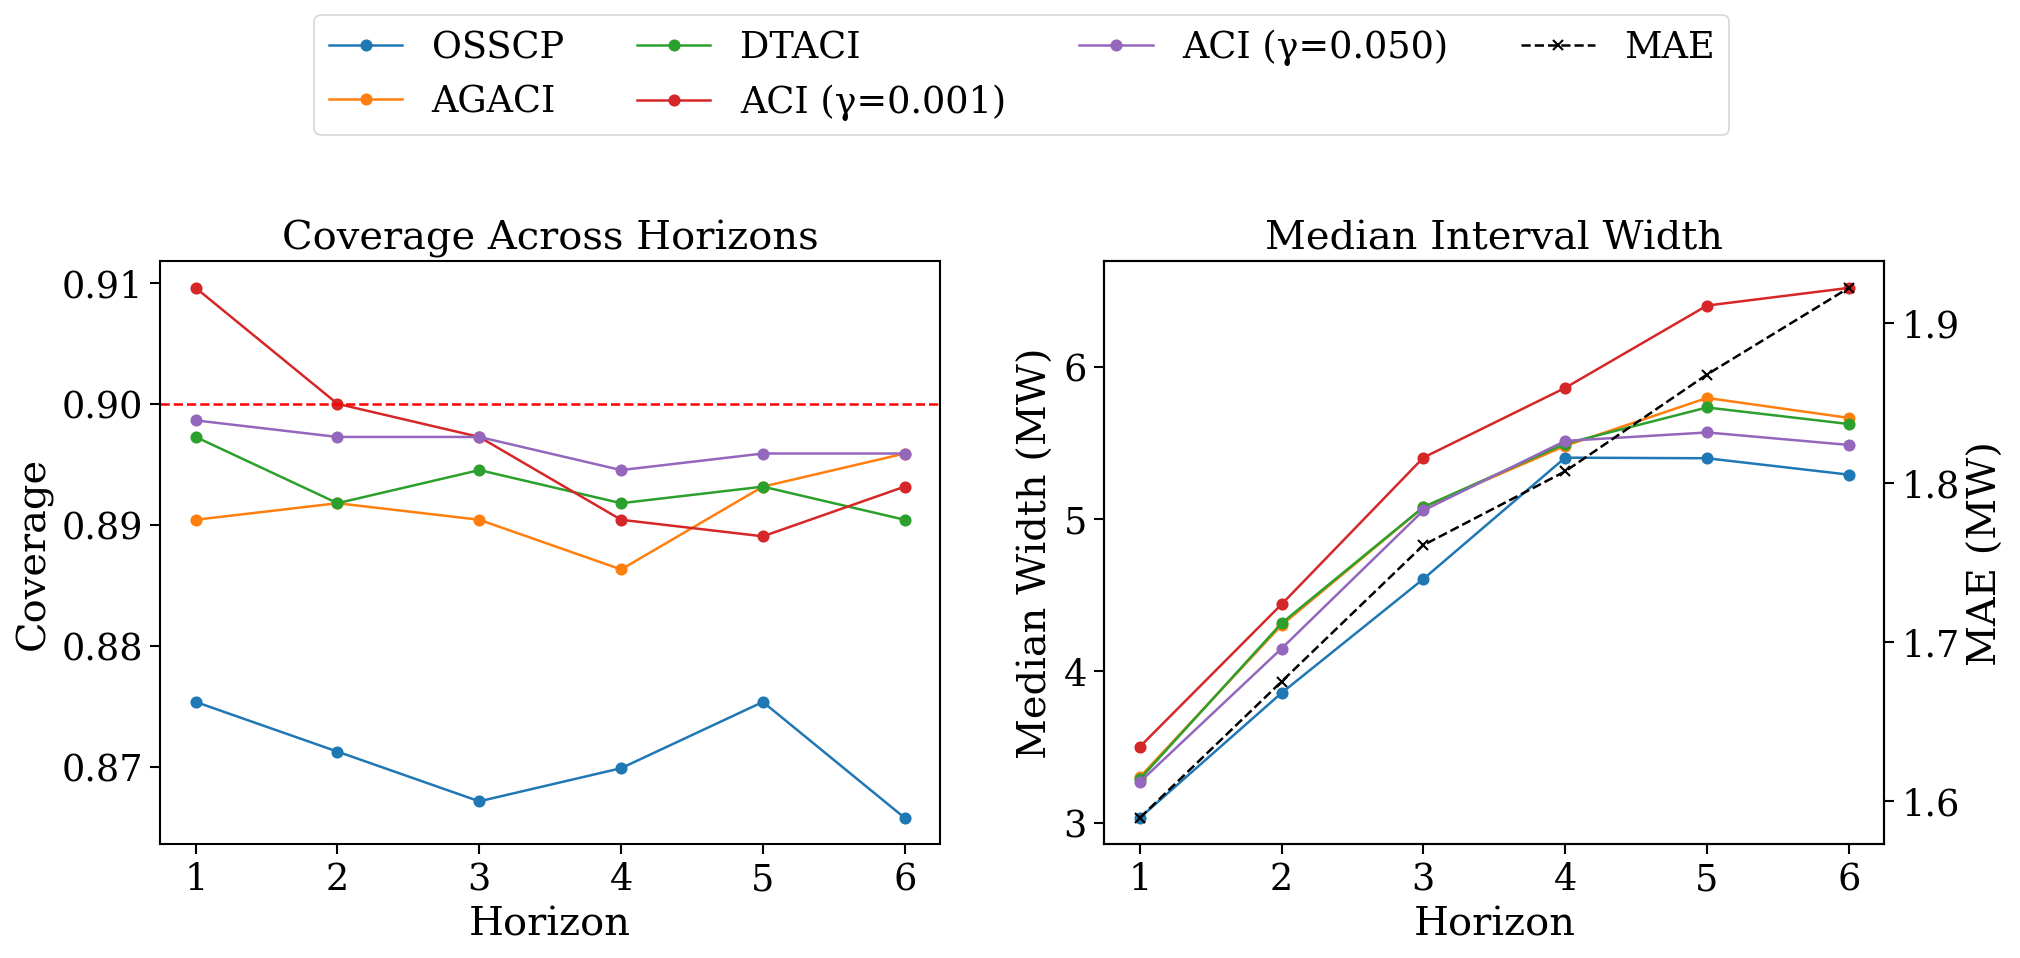

In [128]:
generate_performance_report(
    results_subdict=results["STGCN"],
    forecasts=forecasts,
    point_methods=["STGCN", "ARIMA", "LGBM"],
    actual_col="y",
    horizon_col="H",
    error_metric="MAE"
)

### Sample plot of intervals (volatile regime)

In [ ]:
def to_dataframes(all_results: dict) -> dict:
    """Converts nested results into a dictionary of clean, sorted DataFrames."""
    
    final_output = {}
    for model_name, results_by_horizon in all_results.items():
        
        # 1. Collect all data pieces from each horizon
        temp_data = defaultdict(lambda: defaultdict(list))
        for h in sorted(results_by_horizon.keys()):
            for method, metrics in results_by_horizon[h].items():
                for key, value in metrics.items():
                    if isinstance(value, np.ndarray):
                        temp_data[method][key].append(value)

        # 2. Build the DataFrame for each method
        model_dfs = {}
        for method, data in temp_data.items():
            combined = {k: np.concatenate(v) for k, v in data.items()}
            if "timestamps" not in combined:
                continue

            df = pd.DataFrame(
                data={
                    'lower_bound': combined.get('lower_bounds'),
                    'upper_bound': combined.get('upper_bounds'),
                    'alpha': combined.get('alpha_hist'),
                    'cov': combined.get('cover_hist'),
                    'res': combined.get('res_hist'),
                },
                index=pd.to_datetime(combined["timestamps"])
            ).dropna(axis=1, how='all')

            df = df.sort_index()

            if 'cover_hist' in combined:
                coverage = np.mean(combined['cover_hist'])
                df.attrs['coverage'] = coverage
                df.attrs['miscoverage'] = 1 - coverage
            
            model_dfs[method] = df
            
        final_output[model_name] = model_dfs
        
    return final_output


# dict of dfs 
final_dfs = to_dataframes(results)
print(final_dfs["STGCN"]["agaci"].head())
print("\n--- Summary Stats ---")
print(final_dfs["STGCN"]["agaci"].attrs)

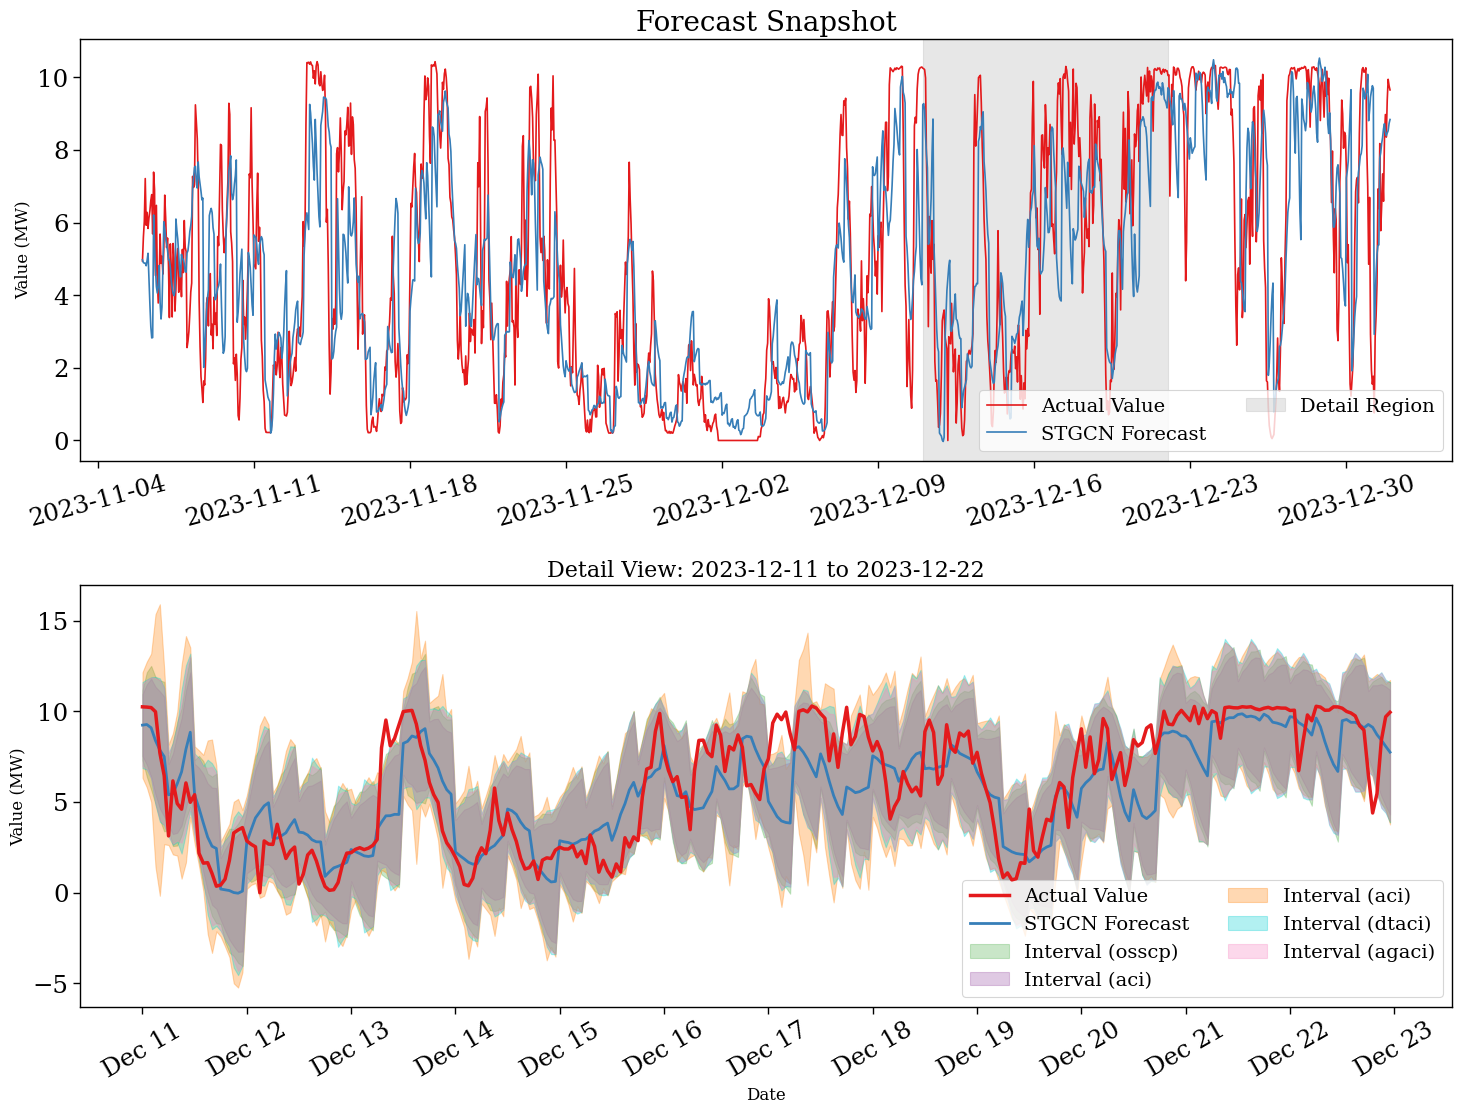

In [ ]:
# zoom config
zoom_start = '2023-12-11'
zoom_end = '2023-12-22'
last_n = 168*5
sns.set_context("paper", font_scale=2) 

fig, (ax1, ax2) = plt.subplots(
    nrows=2, 
    ncols=1, 
    figsize=(15, 12), 
    dpi=100, 
    sharex=False
)

# plot sample
last_n = 168 * 8  # ~2 months of context
ax1.plot(forecasts.index[-last_n:], forecasts['y'].tail(last_n) / 1000, label="Actual Value", color="#E41A1C")  # Red
ax1.plot(forecasts.index[-last_n:], forecasts['STGCN'].tail(last_n) / 1000, label="STGCN Forecast", color="#377EB8")  # Blue

# highlight zoom region
ax1.axvspan(zoom_start, zoom_end, color='#B0B0B0', alpha=0.3, label='Detail Region')
ax1.set_title("Forecast Snapshot", fontsize=20)
ax1.set_ylabel("Value (MW)", fontsize=12)
ax1.legend(ncol=2, loc='lower right', fontsize=14)
ax1.tick_params(axis='x', rotation=15)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=7))


# zooom plot 
forecasts_zoom = forecasts.loc[zoom_start:zoom_end]
ax2.plot(forecasts_zoom.index, forecasts_zoom['y'] / 1000, label="Actual Value", color="#E41A1C", linewidth=2.5, zorder=10)
ax2.plot(forecasts_zoom.index, forecasts_zoom['STGCN'] / 1000, label="STGCN Forecast", color="#377EB8", linewidth=2, zorder=9)

uq_colors = ['#4daf4a', '#984ea3', '#ff7f00', '#00ced1', '#f781bf']  # Green, Purple, Orange, Teal, Pink

stgcn_method_dfs = final_dfs.get('STGCN', {})
for i, (method_name, df) in enumerate(stgcn_method_dfs.items()):
    df_zoom = df.loc[zoom_start:zoom_end]
    ax2.fill_between(
        df_zoom.index,
        df_zoom['lower_bound'] / 1000,  # Scale to MW
        df_zoom['upper_bound'] / 1000,  # Scale to MW
        color=uq_colors[i % len(uq_colors)],
        alpha=0.3,
        label=f'Interval ({method_name.split("_")[0]})'
    )

ax2.set_title(f"Detail View: {zoom_start} to {zoom_end}", fontsize=16)
ax2.set_xlabel("Date", fontsize=12)
ax2.set_ylabel("Value (MW)", fontsize=12)
ax2.legend(ncol=2, loc='lower right', fontsize=14)
ax2.tick_params(axis='x', rotation=30)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax2.xaxis.set_major_locator(mdates.DayLocator(interval=1))

plt.savefig("forecast_snapshot.pdf", dpi=300, bbox_inches='tight')

# full plot
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

#### Metrics

In [ ]:
def calculate_winkler_score(
    predictions_df: pd.DataFrame,
    y_true: pd.Series
) -> float:
    """
    Calculates the mean Winkler Score for a set of prediction intervals.

    Args:
        predictions_df: DataFrame with 'lower_bound', 'upper_bound', and 'alpha' columns,
                        and a DatetimeIndex.
        y_true: Series of true values with a corresponding DatetimeIndex.

    Returns:
        The mean Winkler Score.
    """
    # Align true values with predictions based on the index
    aligned_df = predictions_df.join(y_true.rename('y_true'), how='inner')
    if aligned_df.empty:
        raise ValueError("No matching timestamps found between predictions and true values.")

    scores = []
    for _, row in aligned_df.iterrows():
        lower = row['lower_bound']
        upper = row['upper_bound']
        y = row['y_true']
        alpha = row['alpha']
        
        # Calculate the interval width (sharpness)
        width = upper - lower
        
        score = 0
        # Penalty for y being below the lower bound
        if y < lower:
            score = width + (2 / alpha) * (lower - y)
        # Penalty for y being above the upper bound
        elif y > upper:
            score = width + (2 / alpha) * (y - upper)
        # Score is just the width if y is inside the interval
        else:
            score = width
        
        scores.append(score)
        
    return np.mean(scores)

In [ ]:
sample_index = final_dfs["STGCN"]["agaci"].index
y_true_series = pd.Series(forecasts["y"].tail(len(sample_index)), index=sample_index)

winkler_scores = {}
for model_name, methods in final_dfs.items():
    winkler_scores[model_name] = {}
    for method_name, df in methods.items():
        try:
            score = calculate_winkler_score(df, y_true_series)
            winkler_scores[model_name][method_name] = score
            print(f"Winkler Score for {model_name} - {method_name}: {score:.4f}")
        except ValueError as e:
            print(f"Could not calculate score for {model_name} - {method_name}: {e}")
print("\n--- Summary of Winkler Scores ---")
print(winkler_scores)

Winkler Score for STGCN - osscp: 4802.4592
Winkler Score for STGCN - aci_gamma0.001: 5329.9858
Winkler Score for STGCN - aci_gamma0.050: 5240.3968
Winkler Score for STGCN - dtaci: 5137.4910
Winkler Score for STGCN - agaci: 5112.4014
Winkler Score for LGBM - osscp: 6767.0026
Winkler Score for LGBM - aci_gamma0.001: 7477.8044
Winkler Score for LGBM - aci_gamma0.050: 7418.2069
Winkler Score for LGBM - dtaci: 7295.4974
Winkler Score for LGBM - agaci: 7199.0866
Winkler Score for ARIMA - osscp: 10086.1409
Winkler Score for ARIMA - aci_gamma0.001: 10565.8971
Winkler Score for ARIMA - aci_gamma0.050: 9690.2414
Winkler Score for ARIMA - dtaci: 9964.0153
Winkler Score for ARIMA - agaci: 9895.5631

--- Summary of Winkler Scores ---
{'STGCN': {'osscp': np.float64(4802.459237796314), 'aci_gamma0.001': np.float64(5329.985785093264), 'aci_gamma0.050': np.float64(5240.3968075686935), 'dtaci': np.float64(5137.491030967399), 'agaci': np.float64(5112.401406302953)}, 'LGBM': {'osscp': np.float64(6767.0026